## <font color='red'>Logistic Regression and K-NN Classification with BoW features</font>

### Preprocessing

### Usupervised Learning of Visual Words

Train_images shape (11960, 1024)
Test_images shape  (10396, 1024)


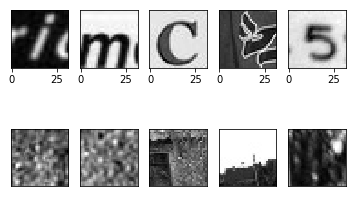

In [9]:
# Read the Dataset (Raw Pixels data). Use same dataset as in Project_PR1.
import pickle
import gzip
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

with gzip.open('./raw_pixels_dataset_5980.pklz','rb') as f:
  (train_labels,train_images,test_labels,test_images) = pickle.load(f)

# Show a few samples of the positive and negative classes.
#numbero of training labels == 0
num_text = sum(train_labels==0)
fig = plt.figure()
for i in range(1,6):
    #the subplot take the i position in the greed with 2 rows and 5 columns
    ax = fig.add_subplot(2, 5, i)
    #random.radint return a numpy array of integer numbers between 0 and num_text (rows of the training set)
    ax.imshow(np.reshape(train_images[np.random.randint(0,num_text),:],[32,32]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = fig.add_subplot(2, 5, i+5)
    
    #Here is for the background, before for the letter (second part of the training set)
    ax.imshow(np.reshape(train_images[np.random.randint(num_text,train_labels.shape[0]),:],[32,32]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


Images shape (11960, 32, 32)
Patches shape before reshaping (191360, 8, 8)
Patches shape (191360, 64)


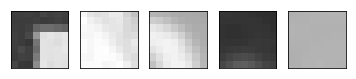

In [12]:
# Extract patches (of 8x8 pixels) from train images
import numpy as np

#3-dimensional polyhedral
images = train_images.reshape((-1,32,32)).astype('float32')/255 # reshape images to 32x32
                                                                # and scale values to (0., 1.)
print("Images shape " + str(images.shape))

# Collect image patches with sliding window (8x8) in each train image sample
PATCH_SIZE=8;
STEP_SIZE =8;

#initialize to zero a patches array of three dimension 0x8x8
patches = np.zeros((0,PATCH_SIZE,PATCH_SIZE))

#the cycle is thought for operating on a single image but the operation are performed on all the training set each cycle
for x in range(0, 32-PATCH_SIZE+1, STEP_SIZE):
    for y in range(0, 32-PATCH_SIZE+1, STEP_SIZE):
        patches = np.concatenate((patches, images[:,x:x+PATCH_SIZE,y:y+PATCH_SIZE]), axis=0)

print("Patches shape before reshaping " + str(patches.shape))

#reshaping of the three dimensional numpy array in two dimensions, so each image is converted in a 64 array of one dimension
patches = patches.reshape((patches.shape[0],-1))
print("Patches shape " + str(patches.shape))

# Visualize a few patches
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(np.reshape(patches[i],[PATCH_SIZE,PATCH_SIZE]), cmap=plt.cm.gray, vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Now we contrast normalize our patches in order to gain illumination invariance. Each patch is normalized by pixel-wise subtracting its mean and dividing by its standard deviation.

/Users/raffaelebongo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


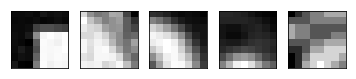

In [13]:
# PreProcessing (I) Contrast Normalization of Patches

#Normalizing we obtain more illumination contrast
#axis=1 is the y-axe, so we take the mean for each 64 image array
mu = patches.mean(axis=1) # mean values
#same for the variance
sigma = patches.std(axis=1) + np.ptp(patches, axis=1)/20.0 # standard deviation (plus a small value)

patches = (patches-mu.reshape([-1,1]))/(sigma.reshape([-1,1])) # subtract the mean and divide by std

# Set NaN values (if exist) to 0
w = np.isnan(patches);
patches[w] = 0;

# Visualize a few Constrast Normalized patches
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(np.reshape(patches[i],[PATCH_SIZE,PATCH_SIZE]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Next we perform ZCA whitening of the patches

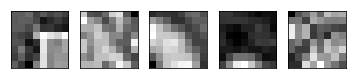

In [14]:
# PreProcessing (II) ZCA Whitening of normalized patches

eig_values, eig_vec = np.linalg.eig(np.cov(patches.T))
epsilon = 0.01
pca = eig_vec.dot(np.diag((eig_values+epsilon)**-0.5).dot(eig_vec.T))


M =  patches.mean(axis=0)
patches = patches -  M # subtract average value
patches = np.dot(patches, pca) # perform pca whitening


# Visualize a few PreProcessed patches
fig = plt.figure()
for i in range(1,6):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(np.reshape(patches[i],[PATCH_SIZE,PATCH_SIZE]), cmap=plt.cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Once we have our preprocessed training patches we can perform Unsupervised Learning analysis (K-means clustering) to learn the K visual Words vocabulary.  Then we'll use these vocabulary to represent an image as an histogram of the occurrences of its Words.

In [17]:
# K-means clustering to learn K visual_words from data
from sklearn.cluster import KMeans

NUM_VISUAL_WORDS = 64

km = KMeans(n_clusters=NUM_VISUAL_WORDS, max_iter=50, n_init=1, verbose=False)
km.fit(patches)

visual_words = km.cluster_centers_
#is 64x64 because patches contains images shaped as array of 64 elements.
print("Visual_words shape " + str(visual_words.shape))

Visual_words shape (64, 64)


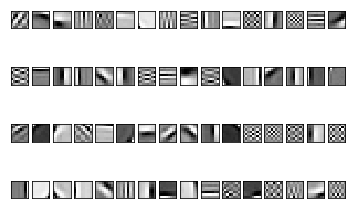

In [18]:
# Visualize the learned vocabulary of Visual Words

from matplotlib import pyplot as plt
import matplotlib.cm as cm
#%pylab inline

fig = plt.figure()
num_col = int(np.ceil(float(NUM_VISUAL_WORDS)/4))
for i in xrange(NUM_VISUAL_WORDS):
    ax = fig.add_subplot(4, num_col, i+1)
    visual_word_ = visual_words[i,:]
    visual_word_ = visual_word_.reshape(PATCH_SIZE,PATCH_SIZE);
    ax.imshow(visual_word_, interpolation='none', cmap = cm.Greys_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Extract Image features using Bag of Words

A Bag of Visual Words is a histogram of occurrence counts of the vocabulary words.

In our case we have 64 Words in the vocabulary, hence the histogram will have 64 bins. 

To represent an image we'll extract image patches, preprocess them, and find its Nearest Neighbor Word in the vocabulary. Finally, each Nearest Neighbor found increments in 1 unit the value of its respective bin in the BoW histogram. 

In [19]:
# Learn a KNN classifier, Each visual Word represents one class
# In this case KNN is used simply as a way to search of the nearest neighbor Visual Word 
# in our vocabulary.
from sklearn.neighbors import KNeighborsClassifier

#we choose the only one nearest neighbors
neig = KNeighborsClassifier(n_neighbors=1)

#We use the visula_words as training data and the numbers between 0 and 64 as target values
neig.fit(visual_words,range(0,NUM_VISUAL_WORDS));

In [23]:
# Extract features from train images
train_features = np.zeros((images.shape[0],visual_words.shape[0]));

for i in range(0,images.shape[0]): # for each image

  # Do sliding window (8x8) in each image to extract patches
  #    then normalize, whiten and build the Bag of Words histogram
  for x in range(0,32-PATCH_SIZE+1,STEP_SIZE):
    for y in range(0,32-PATCH_SIZE+1,STEP_SIZE):
        patch = images[i,x:x+PATCH_SIZE,y:y+PATCH_SIZE]
        patch = patch.reshape((1,-1))
        # PreProcessing (I): Normalize
        mu = patch.mean(axis=1) # mean values
        sigma = patch.std(axis=1) + max(np.ptp(patch, axis=1)/20.0, 0.0001) # standard deviation 
                                                               # (plus a small value)
        patch = (patch-(mu[np.newaxis,:]).T)/(sigma[np.newaxis,:]).T
        # Set NaN values to 0
        w = np.isnan(patch);
        patch[w] = 0;
        
        # PreProcessing (II): ZCA whitening
        patch = patch - M # subtract average value
        patch = np.dot(patch, pca) # perform pca whitening
        
        # BoW
        nn = neig.predict(patch)
        train_features[i,nn] = train_features[i,nn] + 1;
        
    train_features[i,:] = train_features[i,:]/max(train_features[i,:]) # Histogram normalization

In [ ]:
# If you want to save your training features
import pickle
import gzip

with gzip.open('./BoW_train_features.pklz','wb') as f:
    pickle.dump((train_labels,train_features),f,pickle.HIGHEST_PROTOCOL)

In [20]:
# Extract features from test images
images = test_images.reshape((-1,32,32)).astype('float32')/255
test_features = np.zeros((images.shape[0],visual_words.shape[0]));

for i in range(0,images.shape[0]): #for each image
    
  # Do sliding window (8x8) in each image to extract patches
  #    then normalize, whiten and build the Bag of Words histogram
    for x in range(0,32-PATCH_SIZE+1,STEP_SIZE):
        for y in range(0,32-PATCH_SIZE+1,STEP_SIZE):
            patch = images[i,x:x+PATCH_SIZE,y:y+PATCH_SIZE]
            patch = patch.reshape((1,-1))
            # PreProcessing (I): Normalize
            mu = patch.mean(axis=1) # mean values
            sigma = patch.std(axis=1) + max(np.ptp(patch, axis=1)/20.0, 0.0001) # standard deviation 
                                                               # (plus a small value)
            patch = (patch-(mu[np.newaxis,:]).T)/(sigma[np.newaxis,:]).T
            # Set NaN values to 0
            w = np.isnan(patch);
            patch[w] = 0;
        
            # PreProcessing (II): ZCA whitening
            patch = patch - M # subtract average value
            patch = np.dot(patch, pca) # perform pca whitening

            # BoW
            #increment in the same time all the class labels found
            nn = neig.predict(patch)
            test_features[i,nn] = test_features[i,nn] + 1;
        
    test_features[i,:] = test_features[i,:]/max(test_features[i,:])  # Histogram normalization

In [21]:
# If you want to save your test features
import pickle
import gzip

with gzip.open('./BoW_test_features.pklz','wb') as f:
    pickle.dump((test_labels,test_features),f,pickle.HIGHEST_PROTOCOL)

## <font color='red'>Logistic Regression classification with BoW features.</font>



Data preprocessing in order to have a BoW representation of the dataset. Contrast Normalization and PCA whitening are
performed

/Users/raffaelebongo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in divide


Vocabularies of learned Visual Words


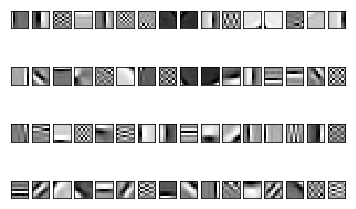

In [6]:
import pickle
import gzip
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
import matplotlib.cm as cm
from sklearn.neighbors import KNeighborsClassifier

with gzip.open('./raw_pixels_dataset_5980.pklz','rb') as f:
  (train_labels,train_images,test_labels,test_images) = pickle.load(f)

  # 3-dimensional polyhedral
  images = train_images.reshape((-1, 32, 32)).astype('float32') / 255  # reshape images to 32x32
  # and scale values to (0., 1.)



#PATCHES EXTRACTION
# Collect image patches with sliding window (8x8) in each train image sample
PATCH_SIZE = 8
STEP_SIZE = 8

# initialize to zero a patches array of three dimension 0x8x8
patches = np.zeros((0, PATCH_SIZE, PATCH_SIZE))

# the cycle is thought for operating on a single image but the operation are performed on all the training set each cycle
for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
    for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        patches = np.concatenate((patches, images[:, x:x + PATCH_SIZE, y:y + PATCH_SIZE]), axis=0)

# reshaping of the three dimensional numpy array in two dimensions, so each image is converted in a 64 array of one dimension
patches = patches.reshape((patches.shape[0], -1))


# PreProcessing (I) Contrast Normalization of Patches
#Normalizing we obtain more illumination contrast
#axis=1 is the y-axe, so we ta
# ke the mean for each 64 image array
mu = patches.mean(axis=1) # mean values
#same for the variance
sigma = patches.std(axis=1) + np.ptp(patches, axis=1)/20.0 # standard deviation (plus a small value)

patches = (patches-mu.reshape([-1,1]))/(sigma.reshape([-1,1])) # subtract the mean and divide by std

# Set NaN values (if exist) to 0
w = np.isnan(patches)
patches[w] = 0


# PreProcessing (II) ZCA Whitening of normalized patches
eig_values, eig_vec = np.linalg.eig(np.cov(patches.T))
epsilon = 0.01
pca = eig_vec.dot(np.diag((eig_values+epsilon)**-0.5).dot(eig_vec.T))


M = patches.mean(axis=0)
# subtract average value
patches = patches - M
# perform pca whitening
patches = np.dot(patches, pca)


# K-means clustering to learn K visual_words from data
from sklearn.cluster import KMeans

NUM_VISUAL_WORDS = 64

km = KMeans(n_clusters=NUM_VISUAL_WORDS, max_iter=50, n_init=1, verbose=False)
km.fit(patches)

visual_words = km.cluster_centers_
#is 64x64 because patches contains images shaped as array of 64 elements.

#we choose the only one nearest neighbors
neig = KNeighborsClassifier(n_neighbors=1)

#We use the visula_words as training data and the numbers between 0 and 64 as target values
neig.fit(visual_words,range(0,NUM_VISUAL_WORDS))

# Extract features from train images
train_features = np.zeros((images.shape[0], visual_words.shape[0]))

for i in range(0, images.shape[0]):  # for each image

    # Do sliding window (8x8) in each image to extract patches
    #    then normalize, whiten and build the Bag of Words histogram
    for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
            patch = images[i, x:x + PATCH_SIZE, y:y + PATCH_SIZE]
            patch = patch.reshape((1, -1))

            # PreProcessing (I): Normalize
            mu = patch.mean(axis=1)  # mean values
            sigma = patch.std(axis=1) + max(np.ptp(patch, axis=1) / 20.0, 0.0001)  # standard deviation
            # (plus a small value)
            patch = (patch - (mu[np.newaxis, :]).T) / (sigma[np.newaxis, :]).T
            # Set NaN values to 0
            w = np.isnan(patch)
            patch[w] = 0

            # PreProcessing (II): ZCA whitening
            patch = patch - M  # subtract average value
            patch = np.dot(patch, pca)  # perform pca whitening

            # BoW
            nn = neig.predict(patch)
            train_features[i, nn] = train_features[i, nn] + 1

    train_features[i, :] = train_features[i, :] / max(train_features[i, :])  # Histogram normalization


with gzip.open('./BoW_train_features.pklz','wb') as f:
    pickle.dump((train_labels,train_features),f,pickle.HIGHEST_PROTOCOL)


# Extract features from test images
images = test_images.reshape((-1, 32, 32)).astype('float32') / 255
test_features = np.zeros((images.shape[0], visual_words.shape[0]))

for i in range(0, images.shape[0]):  # for each image

    # Do sliding window (8x8) in each image to extract patches
    #    then normalize, whiten and build the Bag of Words histogram
    for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
            patch = images[i, x:x + PATCH_SIZE, y:y + PATCH_SIZE]
            patch = patch.reshape((1, -1))
            # PreProcessing (I): Normalize
            mu = patch.mean(axis=1)  # mean values
            sigma = patch.std(axis=1) + max(np.ptp(patch, axis=1) / 20.0, 0.0001)  # standard deviation
            # (plus a small value)
            patch = (patch - (mu[np.newaxis, :]).T) / (sigma[np.newaxis, :]).T
            # Set NaN values to 0
            w = np.isnan(patch)
            patch[w] = 0

            # PreProcessing (II): ZCA whitening
            patch = patch - M  # subtract average value
            patch = np.dot(patch, pca)  # perform pca whitening

            # BoW
            # increment in the same time all the class labels found
            nn = neig.predict(patch)
            test_features[i, nn] = test_features[i, nn] + 1

    test_features[i, :] = test_features[i, :] / max(test_features[i, :])  # Histogram normalization

with gzip.open('./BoW_test_features.pklz','wb') as f:
    pickle.dump((test_labels,test_features),f,pickle.HIGHEST_PROTOCOL)
    
    print('Vocabularies of learned Visual Words')
    
fig = plt.figure()
num_col = int(np.ceil(float(NUM_VISUAL_WORDS)/4))
for i in xrange(NUM_VISUAL_WORDS):
    ax = fig.add_subplot(4, num_col, i+1)
    visual_word_ = visual_words[i,:]
    visual_word_ = visual_word_.reshape(PATCH_SIZE,PATCH_SIZE);
    ax.imshow(visual_word_, interpolation='none', cmap = cm.Greys_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

We set max_iterations=100000, alpha=0.5 and threshold to 0.45.

We have analyzed the results counting the false positive and the false negative and computing for such a threshold Accuracy, Precision and Recall values.

We have applied the same analysis to the BoW data representation but without the whitening procedure and we compared 
the results.

Confusion matrix and Precision/Recall graphs are reported.

Global minimum reached
The gradient is:
Classification starts...
Threshold: 0.5
fp: 
837.0
fn: 
606.0
()
Test Accuracy : 0.8611966140823394
Test Precision : 0.8458279609504513
Test Recall : 0.8834166987302808
Average precision-recall score: 0.88
Confusion matrix:
[[4361  837]
 [ 606 4592]]


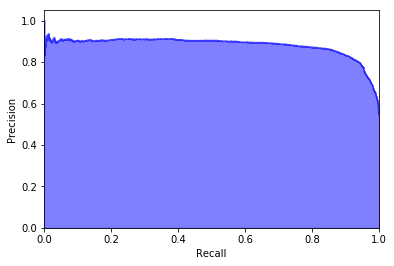

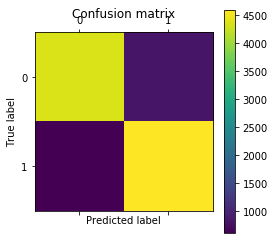

In [25]:
import pickle
import gzip
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
import matplotlib.cm as cm
from sklearn.neighbors import KNeighborsClassifier

def sigmoid(X):
    '''
    Computes the Sigmoid function of the input argument X.
    '''
    return 1.0 / (1 + np.exp(-X))


def GradientDescent(x, y, max_iterations=100000, alpha=0.5):
    m, n = x.shape  # number of samples, number of features ( row vectors )

    # y must be a column vector
    y = y.reshape(m, 1)

    # initialize the parameters ( column )
    theta = np.ones(shape=(n, 1))
    error_0 = 0

    # Repeat until convergence (or max_iterations)
    for iteration in range(max_iterations):

        h = sigmoid(np.dot(x, theta))

        error = (h - y)
        gradient = np.dot(x.T, error) / m
        
        if np.absolute(error - error_0).all() < 10 ** (-15):
            print 'Global minimum reached'
            print 'The gradient is:'
            return theta

        theta = theta - alpha * gradient
        error_0 = error

    return theta


def classifyVector(X, theta, thr):
    '''
    Evaluate the Logistic Regression model h(x) with theta parameters,
    and returns the predicted label of x.
    comes out one value of the sigmoid's parameter
    '''
    prob = sigmoid(sum(np.dot(X, theta)))
    if prob > thr:
        return 1.0
    else:
        return 0.0


def classifyProb(X, theta):
    prob = sigmoid(sum(np.dot(X, theta)))
    return prob


# START

with gzip.open(
        './BoW_train_features.pklz',
        'rb') as f:
    (train_labels, train_features) = pickle.load(f)

    with gzip.open(
            './BoW_test_features.pklz',
            'rb') as f:
        (test_labels, test_features) = pickle.load(f)

w1 = GradientDescent(train_features, train_labels)

fp = 0
fn = 0
tp = 0
thr = 0.5
y_test_score = []

print 'Classification starts...'

for i in range(test_features.shape[0]):
    x = classifyVector(test_features[i, :], w1, thr)
    y_test_score.append(x)
    if x == 1.0 and x != test_labels[i]:
        fp += 1.0

    if x == 0.0 and x != test_labels[i]:
        fn += 1.0
    
    if x == 1.0 and x == test_labels[i]:
        tp += 1.0

print("Threshold: " + str(thr))
print 'fp: '
print(fp)
print 'fn: '
print(fn)
print ()

# testing the the algorithm
y_test_score1 = [classifyProb(test_features[i, :], w1) for i in range(test_features.shape[0])]

average_precision = average_precision_score(test_labels, y_test_score1)

# After the training
# After the training
print "Test Accuracy : " + str(accuracy_score(test_labels, y_test_score))

print "Test Precision : " + str(
    precision_score(test_labels, y_test_score))
print "Test Recall : " + str(
    recall_score(test_labels, y_test_score))

# precison recall graph on the test dataset

precision, recall, thresholds = precision_recall_curve(test_labels, y_test_score1, 1)

plt.plot(recall, precision, color='b', alpha=0.5,
         drawstyle='steps-post')
plt.fill_between(recall, precision, step='post', alpha=0.5,
                 color='b')

print('Average precision-recall score: {0:0.2f}'.format(
    average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Plot the confusion matrix on test data
cm = confusion_matrix(test_labels, y_test_score)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()


Data preprocessing in order to have a BoW representation of the dataset. Contrast Normalization and PCA whitening are not performed in the features extraction process and in the vocabulary computation procesess.

Images shape (11960, 32, 32)
Patches shape before reshaping (191360, 8, 8)
Patches shape (191360, 64)
Visual_words shape (64, 64)


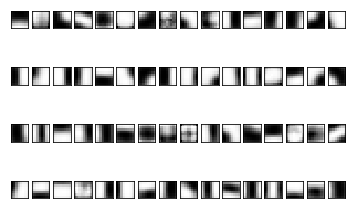

In [8]:
# Read the Dataset (Raw Pixels data). Use same dataset as in Project_PR1.
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm

with gzip.open('./raw_pixels_dataset_5980.pklz','rb') as f:
  (train_labels,train_images,test_labels,test_images) = pickle.load(f)


#3-dimensional polyhedral
images = train_images.reshape((-1,32,32)).astype('float32')/255 # reshape images to 32x32
                                                                # and scale values to (0., 1.)
print("Images shape " + str(images.shape))

# Collect image patches with sliding window (8x8) in each train image sample
PATCH_SIZE=8;
STEP_SIZE =8;

#initialize to zero a patches array of three dimension 0x8x8
patches = np.zeros((0,PATCH_SIZE,PATCH_SIZE))

#the cycle is thought for operating on a single image but the operation are performed on all the training set each cycle
for x in range(0, 32-PATCH_SIZE+1, STEP_SIZE):
    for y in range(0, 32-PATCH_SIZE+1, STEP_SIZE):
        patches = np.concatenate((patches, images[:,x:x+PATCH_SIZE,y:y+PATCH_SIZE]), axis=0)

print("Patches shape before reshaping " + str(patches.shape))

#reshaping of the three dimensional numpy array in two dimensions, so each image is converted in a 64 array of one dimension
patches = patches.reshape((patches.shape[0],-1))
print("Patches shape " + str(patches.shape))

# K-means clustering to learn K visual_words from data
from sklearn.cluster import KMeans

NUM_VISUAL_WORDS = 64

km = KMeans(n_clusters=NUM_VISUAL_WORDS, max_iter=50, n_init=1, verbose=False)
km.fit(patches)

visual_words = km.cluster_centers_
#is 64x64 because patches contains images shaped as array of 64 elements.
print("Visual_words shape " + str(visual_words.shape))

# Learn a KNN classifier, Each visual Word represents one class
# In this case KNN is used simply as a way to search of the nearest neighbor Visual Word
# in our vocabulary.
from sklearn.neighbors import KNeighborsClassifier

#we choose the only one nearest neighbors
neig = KNeighborsClassifier(n_neighbors=1)

#We use the visula_words as training data and the numbers between 0 and 64 as target values
neig.fit(visual_words,range(0,NUM_VISUAL_WORDS));

# Extract features from train images
train_features = np.zeros((images.shape[0], visual_words.shape[0]));

for i in range(0, images.shape[0]):  # for each image

    # Do sliding window (8x8) in each image to extract patches
    #    then normalize, whiten and build the Bag of Words histogram
    for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
            patch = images[i, x:x + PATCH_SIZE, y:y + PATCH_SIZE]
            patch = patch.reshape((1, -1))

            # BoW
            nn = neig.predict(patch)
            train_features[i, nn] = train_features[i, nn] + 1;

    train_features[i, :] = train_features[i, :] / max(train_features[i, :])  # Histogram normalization


with gzip.open('./Bow_noPrepVoc&FE_train','wb') as f:
    pickle.dump((train_labels,train_features),f,pickle.HIGHEST_PROTOCOL)

# Extract features from test images
images = test_images.reshape((-1, 32, 32)).astype('float32') / 255
test_features = np.zeros((images.shape[0], visual_words.shape[0]));

for i in range(0, images.shape[0]):  # for each image

    # Do sliding window (8x8) in each image to extract patches
    #    then normalize, whiten and build the Bag of Words histogram
    for x in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
        for y in range(0, 32 - PATCH_SIZE + 1, STEP_SIZE):
            patch = images[i, x:x + PATCH_SIZE, y:y + PATCH_SIZE]
            patch = patch.reshape((1, -1))

            # BoW
            # increment in the same time all the class labels found
            nn = neig.predict(patch)
            test_features[i, nn] = test_features[i, nn] + 1;

    test_features[i, :] = test_features[i, :] / max(test_features[i, :])  # Histogram normalization

with gzip.open('./Bow_noPrepVoc&FE_test','wb') as f:
    pickle.dump((test_labels,test_features),f,pickle.HIGHEST_PROTOCOL)
    

fig = plt.figure()
num_col = int(np.ceil(float(NUM_VISUAL_WORDS)/4))
for i in xrange(NUM_VISUAL_WORDS):
    ax = fig.add_subplot(4, num_col, i+1)
    visual_word_ = visual_words[i,:]
    visual_word_ = visual_word_.reshape(PATCH_SIZE,PATCH_SIZE);
    ax.imshow(visual_word_, interpolation='none', cmap = cm.Greys_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

Logistic regression classification performed with the previous preprocessed data without contrast Normalization and PCA whitening in the features extraction and in the vocabulary computation procesess.

Global minimum reached
--- 32.6801760197 seconds ---
Classification starts...
Threshold: 0.5
fp: 
780.0
fn: 
1731.0
()
Test Accuracy : 0.7584647941515967
Test Precision : 0.8163409465505063
Test Recall : 0.6669873028087726
Average precision-recall score: 0.82


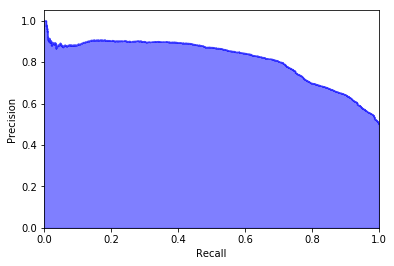

Confusion matrix:
[[4418  780]
 [1731 3467]]


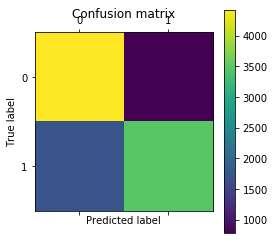

In [24]:
import pickle
import gzip
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
import time

def sigmoid(X):
    '''
    Computes the Sigmoid function of the input argument X.
    '''
    return 1.0 / (1 + np.exp(-X))


def GradientDescent(x, y, max_iterations=100000, alpha=0.5):
    m, n = x.shape  # number of samples, number of features ( row vectors )

    # y must be a column vector
    y = y.reshape(m, 1)

    # initialize the parameters ( column )
    theta = np.ones(shape=(n, 1))
    error_0 = 0
    # Repeat until convergence (or max_iterations)
    for iteration in range(max_iterations):

        h = sigmoid(np.dot(x, theta))

        error = (h - y)
        gradient = np.dot(x.T, error) / m
        # fix it with a threshold
        if np.absolute(error - error_0).all() < 10 ** (-15):
            print 'Global minimum reached'
            return theta

        theta = theta - alpha * gradient
        error_0 = error

    return theta


def classifyVector(X, theta, thr):
    '''
    Evaluate the Logistic Regression model h(x) with theta parameters,
    and returns the predicted label of x.
    comes out one value of the sigmoid's parameter
    '''
    prob = sigmoid(sum(np.dot(X, theta)))
    if prob > thr:
        return 1.0
    else:
        return 0.0


def classifyProb(X, theta):
    prob = sigmoid(sum(np.dot(X, theta)))
    return prob


# START

start_time = time.time()

with gzip.open(
        './Bow_noPrepVoc&FE_train',
        'rb') as f:
    (train_labels, train_features) = pickle.load(f)

    with gzip.open(
            './Bow_noPrepVoc&FE_test',
            'rb') as f:
        (test_labels, test_features) = pickle.load(f)

w1 = GradientDescent(train_features, train_labels)

print("--- %s seconds ---" % (time.time() - start_time))


fp = 0
fn = 0
thr = 0.5
y_test_score = []

print 'Classification starts...'

for i in range(test_features.shape[0]):
    x = classifyVector(test_features[i, :], w1, thr)
    y_test_score.append(x)
    if x == 1.0 and x != test_labels[i]:
        fp += 1.0

    if x == 0.0 and x != test_labels[i]:
        fn += 1.0
        
    if x == 1.0 and x == test_labels[i]:
        tp += 1.0

print("Threshold: " + str(thr))
print 'fp: '
print(fp)
print 'fn: '
print(fn)
print ()

# testing the the algorithm
y_test_score1 = [classifyProb(test_features[i, :], w1) for i in range(test_features.shape[0])]

average_precision = average_precision_score(test_labels, y_test_score1)

# After the training
print "Test Accuracy : " + str(accuracy_score(test_labels, y_test_score))

print "Test Precision : " + str(
    precision_score(test_labels, y_test_score))
print "Test Recall : " + str(
    recall_score(test_labels, y_test_score))
# precison recall graph on the test dataset

precision, recall, thresholds = precision_recall_curve(test_labels, y_test_score1, 1)

plt.plot(recall, precision, color='b', alpha=0.5,
         drawstyle='steps-post')
plt.fill_between(recall, precision, step='post', alpha=0.5,
                 color='b')

print('Average precision-recall score: {0:0.2f}'.format(
    average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Plot the confusion matrix on test data
cm = confusion_matrix(test_labels, y_test_score)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


                                                    SUMMARY TABLE

<table>
    <tr>
        <td> Method </td>
        <td> Test Accuracy </td>
        <td> Precision </td>
        <td> Recall </td>
    </tr>
    <tr>
        <td colspan=2></td>
    </tr>
    
    <tr>
        <td> BoW (No preprocessing in vocabulary and feature extraction process) </td>
        <td> 75.84 %</td>
        <td> 81.63 %</td>
        <td> 66.69 %</td>
    </tr>
    
    <tr>
        <td> BoW  </td>
        <td> 86.11 %</td>
        <td> 84.58 %</td>
        <td> 88.34 %</td>
    </tr>
</table>

As we can see in the summary table, the BoW representation of the data with the preprocessing provide to the Gradient Descent algorithm good material for discriminate between text and non text images, achieving better result than the Grey Level Histograms in all the considered metrics, with a precision recall area that cover the biggest part of the plane of interest.

On the other hand, without the contrast normalization and the decorrelation operation performed with the Withening in the feature extraction process the results, execpt for the precision percentage, are worse than our previous classifier. In fact, the precision recall curve drop rapidly descresing the threshold at the point in which the recall assume value around 0.8 the classifier, from the corresponding threshold and going down, is not more able to discriminate anything, giving a precision of 0.5 that represent a random classifier.

Finally we analyzed the performances of the classifier using also a no preprocessed vocabulary. In this case, the classifier is still able to give better results than the Grey Level Histograms for the Accurancy and the Precision values, but it provides a higher number of false positive which lead to a lower recall value. This is well visualized in the precision-recall curve provided. The different vocabulary of visual words obtained is also visualized and shows how the words appears without the pre-processing. The different is easily visible.

This show the importance of the data preprocessing in order to provide semantically meaningfull features.

## <font color='red'>Effect of vocabulary size in BoW.</font>

<table>
    <tr>
        <td> Num. Visual Words </td>
        <td> Step Size </td>
        <td> Test Accuracy </td>
    </tr>
    <tr>
        <td colspan=2></td>
    </tr>
    
    <tr>
        <td> 32 </td>
        <td> 8 </td>
        <td> 84.59 %</td>
    </tr>
    
    <tr>
        <td> 64 </td>
        <td> 8 </td>
        <td> 86.11 %</td>
    </tr>
    
    <tr>
        <td> 64 </td>
        <td> 4 </td>
        <td> 89.58 %</td>
    </tr>
    
    <tr>
        <td> 128 </td>
        <td> 8 </td>
        <td> 87.41 %</td>
    </tr>
    
    <tr>
        <td> 128 </td>
        <td> 4 </td>
        <td> 89.79 %</td>
    </tr>
</table>

There isn't a strong relation between the number of visual words and the patch size. However, for each number of visual words there is an optimal number of patch size that have to be found. 

With a fixed patch size we need a certain number of visual words in order to represent all the patches in a proper way. Reducing the patch size we finally have a bigger number of patches and so more kind of "particulars" to represent. That makes necessary to have a bigger number of visual words in order to have a fair representation of all the patches computed. However, small-sized patches cannot identify objects well, whereas large-sized patches encounter difficulty in finding similar visual words in the vocabulary. Therefore, medium-sized patches can lead to better retrieval performance.

In order to accomplish the request, we have produced different .pklz files for each number of visual words requested
just moving the parameter NUM_VISUAL_WORDS. After we ran the Gradient Descent algorithm taking as input these files. Below is reported a graph of Test Accuracy obtained as a function of the vocabulary size.

We can see that there is a non linear growth of Test Accurancy as function of the vocabulary size. In fact we notice almost a vertical improment when we move from very small values of words as 4, to bigger values as 8 or 16. Instead
from 32 the imporvement is not so important anymore becoming almost a plateau when the number of words considered is 
256 . This happen when the number of visual words that we try to extract overcome the real number of visual words 
really present in the images. This number is obviously unknown a priori but, with some tests, is possible to find a fair number of that.

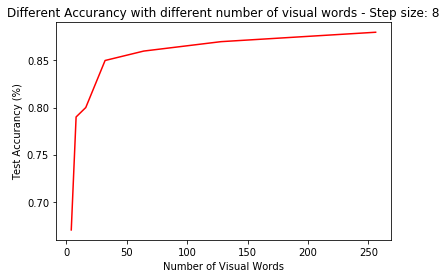

In [19]:
# coding=utf-8
import matplotlib.pyplot as plt

plt.ylabel('Test Accurancy (%)')
plt.xlabel('Number of Visual Words')
plt.title('Different Accurancy with different number of visual words - Step size: 8')
plt.plot([4, 8, 16, 32, 64, 128, 256], [0.67, 0.79, 0.8, 0.85, 0.86, 0.87, 0.88], 'r-')

plt.show()


As we have seen, the increment of the test accurancy as function of the number of visual words is not linear. Instead elapsed time that the gradient descent algorithm spent for the execution, as shown in the subsequent graph, is linear. So the choice of the number of visual words should take into account also the performance that get linearly worse as function of the number of visual words choosen. If the increment of the VW leads to a not so big change in Test Accurancy but make the performance really worse is not convenient apply the change. 

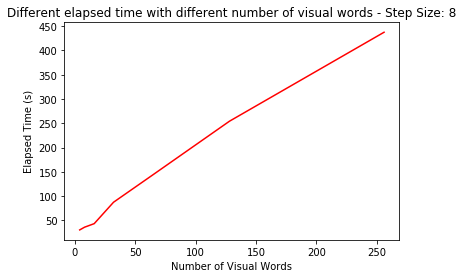

In [11]:
# coding=utf-8
import matplotlib.pyplot as plt

plt.ylabel('Elapsed Time (s)')
plt.xlabel('Number of Visual Words')
plt.title('Different elapsed time with different number of visual words - Step Size: 8')
plt.plot([4, 8, 16, 32, 64, 128, 256], [30.4, 36, 43.3, 87.4, 142.86, 254.31, 437.56], 'r-')

plt.show()


## <font color='red'>K-NN Classifier.</font>

K-NN ALGORITHM: K=1

--- 38.6145880222 seconds ---
fp: 
1271.0
fn: 
965.0
()
Test Accuracy : 0.7849172758753367
Test Precision : 0.7690770348837209
Test Recall : 0.8143516737206618
Confusion matrix:
[[3927 1271]
 [ 965 4233]]


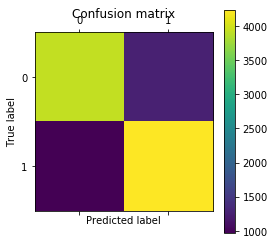

In [28]:
import pickle
import gzip
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# START
with gzip.open(
        './BoW_train_features.pklz',
        'rb') as f:
    (train_labels, train_features) = pickle.load(f)

    with gzip.open(
            './BoW_test_features.pklz',
            'rb') as f:
        (test_labels, test_features) = pickle.load(f)

# WE SET THE CLASSIFIER
# we choose the only one nearest neighbors
neig = KNeighborsClassifier(n_neighbors=1)

neig.fit(train_features, train_labels)

# K-NN classifier
y_test_score = []
start_time = time.time()
for i in range(0, test_features.shape[0]):  # for each image
    img = test_features[i].reshape((1, -1))
    # BoW
    nn = neig.predict(img)
    y_test_score.append(nn[0])

print("--- %s seconds ---" % (time.time() - start_time))

# Testing the the algorithm
fp = 0
fn = 0
tp = 0

for i in range(test_features.shape[0]):

    if y_test_score[i] == 1.0 and y_test_score[i] != test_labels[i]:
        fp += 1.0

    if y_test_score[i] == 0.0 and y_test_score[i] != test_labels[i]:
        fn += 1.0
        
    if y_test_score[i] == 1.0 and y_test_score[i] == test_labels[i]:
        tp += 1.0

print 'fp: '
print(fp)
print 'fn: '
print(fn)
print ()

# After the training
print "Test Accuracy : " + str(accuracy_score(test_labels, y_test_score))

print "Test Precision : " + str(
    precision_score(test_labels, y_test_score))
print "Test Recall : " + str(
    recall_score(test_labels, y_test_score))


# Plot the confusion matrix on test data
cm = confusion_matrix(test_labels, y_test_score)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

K-NN ALGORITHM: K=3

--- 40.2747118473 seconds ---
fp: 
1215.0
fn: 
742.0
()
Test Accuracy : 0.8117545209696037
Test Precision : 0.7857520719449832
Test Recall : 0.8572527895344363
Confusion matrix:
[[3983 1215]
 [ 742 4456]]


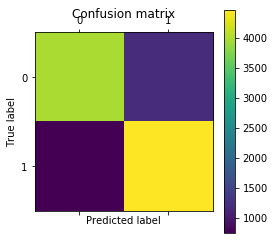

In [29]:
# WE SET THE CLASSIFIER
# we choose the only one nearest neighbors

# START
with gzip.open(
        './BoW_train_features.pklz',
        'rb') as f:
    (train_labels, train_features) = pickle.load(f)

    with gzip.open(
            './BoW_test_features.pklz',
            'rb') as f:
        (test_labels, test_features) = pickle.load(f)

neig = KNeighborsClassifier(n_neighbors=3)

neig.fit(train_features, train_labels)

# K-NN classifier
y_test_score = []
start_time = time.time()
for i in range(0, test_features.shape[0]):  # for each image
    img = test_features[i].reshape((1, -1))
    # BoW
    nn = neig.predict(img)
    y_test_score.append(nn[0])

print("--- %s seconds ---" % (time.time() - start_time))

# Testing the the algorithm
fp = 0
fn = 0
tp = 0

for i in range(test_features.shape[0]):

    if y_test_score[i] == 1.0 and y_test_score[i] != test_labels[i]:
        fp += 1.0

    if y_test_score[i] == 0.0 and y_test_score[i] != test_labels[i]:
        fn += 1.0
        
    if y_test_score[i] == 1.0 and y_test_score[i] == test_labels[i]:
        tp += 1.0

print 'fp: '
print(fp)
print 'fn: '
print(fn)
print ()

# After the training
print "Test Accuracy : " + str(accuracy_score(test_labels, y_test_score))

print "Test Precision : " + str(
    precision_score(test_labels, y_test_score))
print "Test Recall : " + str(
    recall_score(test_labels, y_test_score))


# Plot the confusion matrix on test data
cm = confusion_matrix(test_labels, y_test_score)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

K-NN ALGORITHM: K=7

--- 41.0739130974 seconds ---
fp: 
1205.0
fn: 
650.0
()
Test Accuracy : 0.8215659869180454
Test Precision : 0.7905440639666261
Test Recall : 0.8749519045786841
Confusion matrix:
[[3993 1205]
 [ 650 4548]]


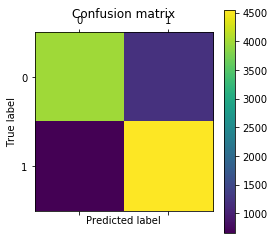

In [30]:
# WE SET THE CLASSIFIER
# we choose the only one nearest neighbors
import pickle
import gzip
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# START
with gzip.open(
        './BoW_train_features.pklz',
        'rb') as f:
    (train_labels, train_features) = pickle.load(f)

    with gzip.open(
            './BoW_test_features.pklz',
            'rb') as f:
        (test_labels, test_features) = pickle.load(f)

neig = KNeighborsClassifier(n_neighbors=7)

neig.fit(train_features, train_labels)

# K-NN classifier
y_test_score = []
start_time = time.time()
for i in range(0, test_features.shape[0]):  # for each image
    img = test_features[i].reshape((1, -1))
    # BoW
    nn = neig.predict(img)
    y_test_score.append(nn[0])



print("--- %s seconds ---" % (time.time() - start_time))

# Testing the the algorithm
fp = 0
fn = 0
tp = 0

for i in range(test_features.shape[0]):

    if y_test_score[i] == 1.0 and y_test_score[i] != test_labels[i]:
        fp += 1.0

    if y_test_score[i] == 0.0 and y_test_score[i] != test_labels[i]:
        fn += 1.0
        
    if y_test_score[i] == 1.0 and y_test_score[i] == test_labels[i]:
        tp += 1.0

print 'fp: '
print(fp)
print 'fn: '
print(fn)
print ()

# After the training
print "Test Accuracy : " + str(accuracy_score(test_labels, y_test_score))

print "Test Precision : " + str(
    precision_score(test_labels, y_test_score))
print "Test Recall : " + str(
    recall_score(test_labels, y_test_score))


# Plot the confusion matrix on test data
cm = confusion_matrix(test_labels, y_test_score)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The classification process using K-NN and logistic regression have different characteristics that have to be taken into account.

The K-NN classifier gives the certainty of reaching a minimum that can or not to be the global one. We don't need a training process so we safe time and resources but, on the other hand, we spent lot of memory for storing our dataset samples and the computation of the distance function can be a very heavy and slow operation. The K-NN classifier usually overfits and we can manage it increasing the k value. In our case, increasing the k value we improve the performances of our classifier but in a non-linear way: when the value become high, keep going to increase it lead to few improvements and much more computational time spent. So is useful to define a trade off and choose the best compromise.

With the Logistic Regression, if we choose a proper error function, we can assure to go always toward the global minimum. Furthemore, We need a training phase in order to find our theta parameters but the classifier computation is usually faster than the K-NN and we don't need the memory for storing the training set.

In our case, we have better results with the LRC in all the metrics considere except for a little better value of recall obtained with K-NN with K=7.

                                                    SUMMARY TABLE

<table>
    <tr>
        <td> Method </td>
        <td> Test Accuracy </td>
        <td> Precision </td>
        <td> Recall </td>
    </tr>
    <tr>
        <td colspan=2></td>
    </tr>
    
    <tr>
        <td> K-NN (K=1) </td>
        <td> 78.49 %</td>
        <td> 76.90 %</td>
        <td> 81.42 %</td>
    </tr>
    
    <tr>
        <td> K-NN (K=3) </td>
        <td> 81.17 %</td>
        <td> 78.57 %</td>
        <td> 85.72 %</td>
    </tr>
    
    <tr>
        <td> K-NN (K=7) </td>
        <td> 82.15 %</td>
        <td> 79.05 %</td>
        <td> 87.49 %</td>
    </tr>
    
    <tr>
        <td> Logistic Regression Classifier ( Visual Words: 128 - Step Size: 4 )</td>
        <td> 89.79 %</td>
        <td> 88.18 %</td>
        <td> 90.41 %</td>
    </tr>
</table>

## <font color='red'> K-NN: COMPARISON BETWEEN THE KNOWN DISTANCE METRICS AND A SUPERVISED LEARNED ONE</font>

We divided this section in two parts. In the first we decided to analyze performances of out K-NN classifier using different distance functions. We used the code that we show below but changing time by time the parameter 'metric' of the 'KNeighborsClassifier' method. Changing this parameter allow us to choice the distance metric used and we saw that the result in terms of accurancy, precision and recall are differents as showed in the graphs below.

The code below is an example of how we computed the various K-NN classification. This one is the case of the mahalanobis distance and is particular because it requires an extra parameter for the computation that is the inverse of the covariance matrix that we computed using the numpy library's functions.

--- 513.150966167 seconds ---
fp: 
1246.0
fn: 
944.0
()
Test Accuracy : 0.7893420546363986
Test Precision : 0.7734545454545455
Test Recall : 0.8183916891111966
Confusion matrix:
[[3952 1246]
 [ 944 4254]]


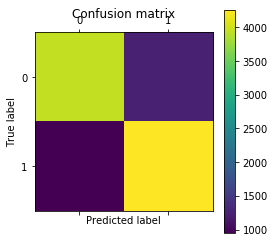

In [31]:
import pickle
import gzip
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# START
with gzip.open(
        './BoW_train_features.pklz',
        'rb') as f:
    (train_labels, train_features) = pickle.load(f)

    with gzip.open(
            './BoW_test_features.pklz',
            'rb') as f:
        (test_labels, test_features) = pickle.load(f)

#Inverve covariance matrix computation
feat = train_features.reshape(-1, train_features.shape[0])
cov = np.ma.cov(feat)
invCov = np.linalg.inv(cov)

#Setting the classifier
neig = KNeighborsClassifier(n_neighbors=1, metric='mahalanobis', metric_params={'V': invCov})

'''We state that it has to use the training set for computing the distance and can give 
   a result between the indexes of the training set lables'''
neig.fit(train_features, range(0, train_features.shape[0]))

# K-NN classifier
y_test_score = []
start_time = time.time()
for i in range(0, test_features.shape[0]):  # for each image
    img = test_features[i].reshape((1, -1))
    nn = neig.predict(img)
    y_test_score.append(train_labels[nn[0]])

print("--- %s seconds ---" % (time.time() - start_time))

# Testing the the algorithm
fp = 0
fn = 0
tp = 0

for i in range(test_features.shape[0]):

    if y_test_score[i] == 1.0 and y_test_score[i] != test_labels[i]:
        fp += 1.0

    if y_test_score[i] == 0.0 and y_test_score[i] != test_labels[i]:
        fn += 1.0
        
    if y_test_score[i] == 1.0 and y_test_score[i] == test_labels[i]:
        tp += 1.0

print 'fp: '
print(fp)
print 'fn: '
print(fn)
print ()

# After the training
print "Test Accuracy : " + str(accuracy_score(test_labels, y_test_score))

print "Test Precision : " + str(
    precision_score(test_labels, y_test_score))
print "Test Recall : " + str(
    recall_score(test_labels, y_test_score))

# Plot the confusion matrix on test data
cm = confusion_matrix(test_labels, y_test_score)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Here we show a bar chart with the various accurancy, precision and recall results for the different metric reported. The results are similar but we can assert that the euclidean distance performs better than the others

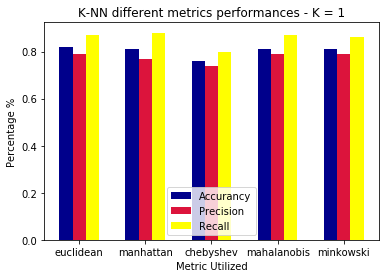

In [37]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt

N = 3


ind = np.arange(5)  # the x locations for the groups
width1 = 0.2

fig, ax = plt.subplots()

accurancy = (0.82, 0.81, 0.76, 0.81, 0.81)
rects1 = ax.bar(ind - width1, accurancy, width1, color='darkblue')

precison = (0.79, 0.77, 0.74, 0.79, 0.79)
rects2 = ax.bar(ind , precison, width1, color='crimson')

recall = (0.87, 0.88, 0.80, 0.87, 0.86)
rects3 = ax.bar(ind + width1, recall, width1, color='yellow')

# add some text for labels, title and axes ticks
ax.set_ylabel('Percentage %')
plt.xlabel('Metric Utilized')

ax.set_xticks( ind )
ax.set_xticklabels(('euclidean', 'manhattan', 'chebyshev', 'mahalanobis', 'minkowski'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Accurancy', 'Precision', 'Recall'))
plt.title('K-NN different metrics performances - K = 1')

plt.show()



Here we show a bar chart with the false positive and false negative in order to make the differences clearer

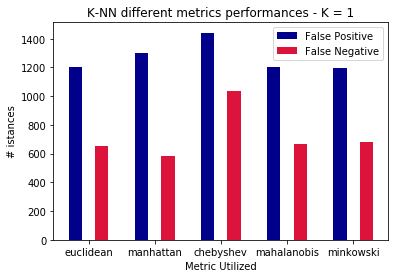

In [40]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt

N = 2

ind = np.arange(5)  # the x locations for the groups
width1 = 0.2

fig, ax = plt.subplots()

fp = (1205, 1302, 1442, 1204, 1194)
rects1 = ax.bar(ind - width1, fp, width1, color='darkblue')

fn = (650, 587, 1038, 670, 684)
rects2 = ax.bar(ind + width1, fn, width1, color='crimson')


# add some text for labels, title and axes ticks
ax.set_ylabel('# istances')
plt.xlabel('Metric Utilized')

ax.set_xticks( ind )
ax.set_xticklabels(('euclidean', 'manhattan', 'chebyshev', 'mahalanobis', 'minkowski'))

ax.legend((rects1[0], rects2[0]), ('False Positive', 'False Negative'))
plt.title('K-NN different metrics performances - K = 1')

plt.show()



In order to find the best metric that fits our problem, we decided to learn this metric using the gradient descent algorithm and our training set. We used as loss function the Hinge Loss, an upper bounded function that allow us to compute a update rule in order to find a minimum during the training. We search an RxR matrix W where R is the number of dimension of each of our observation that lead to a similarity function S(q,t) = q*W*t to assume a big value when q and t are similar and a small value when q and t are different. Below we have provided the implementation of how we learnt the W matrix

In [ ]:
import pickle
import gzip
from random import randint
import numpy as np

def GradientDescent(x, max_iterations=5000, alpha=0.5):
    m, n = x.shape  # number of samples, number of features ( row vectors )

    # initialize the parameters ( column )
    theta = np.ones(shape=(n, n))

    #separete the training set in positive and negative samples
    pos_samples = x[0:x.shape[0] / 2, :]
    neg_samples = x[x.shape[0] / 2:, :]

    # Repeat until convergence (or max_iterations)
    for iteration in range(max_iterations):

        for i in range(0, x.shape[0] / 2):
            #select one sample from each set (positive, query and negative sample)
            p = pos_samples[i]
            q = x[i]
            n = neg_samples[i]

            q = q.reshape(-1, 1)
            p = p.reshape(-1, 1)
            n = n.reshape(-1, 1)

            #evaluate updating condition
            if np.dot(np.dot(q.T, theta), p) < np.dot(np.dot(q.T, theta), n) + 1:
                gradient = np.dot(q, (p - n).T)
                theta = theta + alpha * gradient

        for i in range(x.shape[0] / 2, x.shape[0]):
            #select one sample from each set (positive, query and negative sample)
            p = pos_samples[i - (x.shape[0] / 2)]
            q = x[i]
            n = neg_samples[i - (x.shape[0] / 2)]

            q = q.reshape(-1, 1)
            p = p.reshape(-1, 1)
            n = n.reshape(-1, 1)
            
            #evaluate updating condition
            if np.dot(np.dot(q.T, theta), n) < np.dot(np.dot(q.T, theta), p) + 1:
                gradient = np.dot(q, (n - p).T)
                theta = theta + alpha * gradient

    return theta


# START

with gzip.open(
        './BoW_train_features.pklz',
        'rb') as f:
    (train_labels, train_features) = pickle.load(f)

with gzip.open(
        './BoW_test_features.pklz',
        'rb') as f:
    (test_labels, test_features) = pickle.load(f)

#Call gradient descent function
param_distance_function = GradientDescent(train_features)

#store theta
with gzip.open(
        './ParametersDistanceFunction.pklz',
        'wb') as f:
    pickle.dump(param_distance_function, f, pickle.HIGHEST_PROTOCOL)

print("DONE")


Here we have implented the K-NN classifier that use our learned matrix in order to compute the similarity between the test samples and our training set.

fp: 
604.0
fn: 
1404.0
()
Test Accuracy : 0.8068487879953828
Test Precision : 0.8626648476580264
Test Recall : 0.7298961138899577
Confusion matrix:
[[4594  604]
 [1404 3794]]


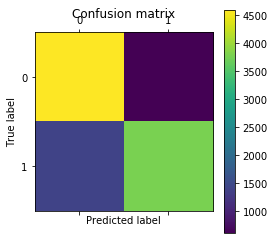

In [35]:
import operator
import pickle
import gzip
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#Similarity function
def learnedDistance(instance1, instance2):

    return np.dot(np.dot(instance1.T, param_distance_function), instance2)


def getNeighbors(trainingSet, testInstance, k):
    distances = []

    for x in range(len(trainingSet)):
        #compute distance
        dist = learnedDistance(testInstance, trainingSet[x])
        #array with tuples containing index of the training set and related distance with the test instance
        distances.append((x, dist))
    #sorting from the bigger similarity to the smallest one
    distances.sort(key=operator.itemgetter(1), reverse=True)
    neighbors = []
    
    #Get the k samples most similar
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors


def getResponse(neighbors, train_labels):

    classVotes = {}
    for x in range(len(neighbors)):
        #get the label of the corresponding neighbour
        response = train_labels[neighbors[x]]
        #update the votes
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    
    #sort by votes the neighbours
    sortedVotes = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
    
    #return the label of the most voted
    return sortedVotes[0][0]

# START

with gzip.open(
        './BoW_train_features.pklz',
        'rb') as f:
    (train_labels, train_features) = pickle.load(f)

    with gzip.open(
            './BoW_test_features.pklz',
            'rb') as f:
        (test_labels, test_features) = pickle.load(f)

with gzip.open(
        './ParametersDistanceFunction.pklz',
        'rb') as f:
    (param_distance_function) = pickle.load(f)

# generate predictions
y_test_score = []
k = 5

#Perform the predictions 
for x in range(len(test_features)):
    neighbors = getNeighbors(train_features, test_features[x], k)
    result = getResponse(neighbors, train_labels)
    y_test_score.append(result)

# Testing the predictions
fp = 0
fn = 0

for i in range(test_features.shape[0]):

    if y_test_score[i] == 1.0 and y_test_score[i] != test_labels[i]:
        fp += 1.0

    if y_test_score[i] == 0.0 and y_test_score[i] != test_labels[i]:
        fn += 1.0

    if y_test_score[i] == 1.0 and y_test_score[i] == test_labels[i]:
        tp += 1.0

print 'fp: '
print(fp)
print 'fn: '
print(fn)
print ()

# testing the the algorithm
y_test_score1 = [classifyProb(test_features[i, :], w1) for i in range(test_features.shape[0])]

average_precision = average_precision_score(test_labels, y_test_score1)

# After the training
print "Test Accuracy : " + str(accuracy_score(test_labels, y_test_score))

print "Test Precision : " + str(
    precision_score(test_labels, y_test_score))
print "Test Recall : " + str(
    recall_score(test_labels, y_test_score))

# Plot the confusion matrix on test data
cm = confusion_matrix(test_labels, y_test_score)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Learned metric K = 7

fp: 
609.0
fn: 
1313.0
()
Test Accuracy : 0.8151212004617161
Test Precision : 0.8644859813084113
Test Recall : 0.7474028472489419
Confusion matrix:
[[4589  609]
 [1313 3885]]


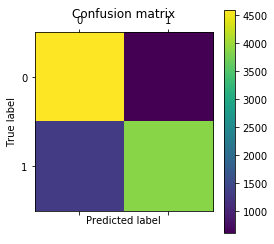

In [36]:
import operator
import pickle
import gzip
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#Similarity function
def learnedDistance(instance1, instance2):

    return np.dot(np.dot(instance1.T, param_distance_function), instance2)


def getNeighbors(trainingSet, testInstance, k):
    distances = []

    for x in range(len(trainingSet)):
        #compute distance
        dist = learnedDistance(testInstance, trainingSet[x])
        #array with tuples containing index of the training set and related distance with the test instance
        distances.append((x, dist))
    #sorting from the bigger similarity to the smallest one
    distances.sort(key=operator.itemgetter(1), reverse=True)
    neighbors = []
    
    #Get the k samples most similar
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors


def getResponse(neighbors, train_labels):

    classVotes = {}
    for x in range(len(neighbors)):
        #get the label of the corresponding neighbour
        response = train_labels[neighbors[x]]
        #update the votes
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    
    #sort by votes the neighbours
    sortedVotes = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
    
    #return the label of the most voted
    return sortedVotes[0][0]

# START

with gzip.open(
        '/BoW_train_features.pklz',
        'rb') as f:
    (train_labels, train_features) = pickle.load(f)

    with gzip.open(
            '/BoW_test_features.pklz',
            'rb') as f:
        (test_labels, test_features) = pickle.load(f)

with gzip.open(
        '/ParametersDistanceFunction.pklz',
        'rb') as f:
    (param_distance_function) = pickle.load(f)

# generate predictions
y_test_score = []
k = 7

#Perform the predictions 
for x in range(len(test_features)):
    neighbors = getNeighbors(train_features, test_features[x], k)
    result = getResponse(neighbors, train_labels)
    y_test_score.append(result)

# Testing the predictions
fp = 0
fn = 0

for i in range(test_features.shape[0]):

    if y_test_score[i] == 1.0 and y_test_score[i] != test_labels[i]:
        fp += 1.0

    if y_test_score[i] == 0.0 and y_test_score[i] != test_labels[i]:
        fn += 1.0

    if y_test_score[i] == 1.0 and y_test_score[i] == test_labels[i]:
        tp += 1.0

print 'fp: '
print(fp)
print 'fn: '
print(fn)
print ()

# testing the the algorithm
y_test_score1 = [classifyProb(test_features[i, :], w1) for i in range(test_features.shape[0])]

average_precision = average_precision_score(test_labels, y_test_score1)

# After the training
print "Test Accuracy : " + str(accuracy_score(test_labels, y_test_score))

print "Test Precision : " + str(
    precision_score(test_labels, y_test_score))
print "Test Recall : " + str(
    recall_score(test_labels, y_test_score))

# Plot the confusion matrix on test data
cm = confusion_matrix(test_labels, y_test_score)
print 'Confusion matrix:'
print (cm)

# Plot confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



The problem that we found in learning the metric, is that it is subjected to overfit being strongly related on our training set. This didn't happen with the other metrics used. The learned metric performs good, with similar accurancy and better precision than the euclidean case, but a much worse recall due to the higher number of false negatives. Future improvements can be applied at the current state appling a regularization term in the gradient descent algorithm or trying to use different loss functions.

A bar chart with the accurancy, precision and recall of the two classifier is visualized.

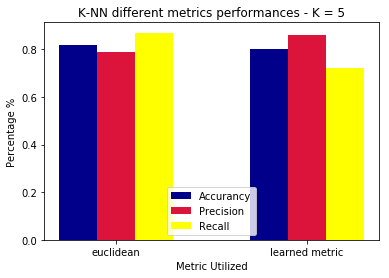

In [39]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt

N = 3


ind = np.arange(2)  # the x locations for the groups
width1 = 0.2

fig, ax = plt.subplots()

accurancy = (0.82, 0.80)
rects1 = ax.bar(ind - width1, accurancy, width1, color='darkblue')

precison = (0.79,  0.86)
rects2 = ax.bar(ind , precison, width1, color='crimson')

recall = (0.87, 0.72)
rects3 = ax.bar(ind + width1, recall, width1, color='yellow')


# add some text for labels, title and axes ticks
ax.set_ylabel('Percentage %')
plt.xlabel('Metric Utilized')
#ax.set_title()
ax.set_xticks( ind )
ax.set_xticklabels(( 'euclidean', 'learned metric'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Accurancy', 'Precision', 'Recall'))
plt.title('K-NN different metrics performances - K = 5')

plt.show()

